In [10]:
import pandas as pd
import os
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

### Getting book transactions from training set

In [14]:
trainusers = None
with open(os.path.join("..", "..", "train_users.json"), "r", encoding="utf-8") as tu:
    trainusers = json.load(tu)


In [16]:
booksrecords = None

with open(os.path.join("..", "commonuser_book.json"), "r") as br:
    booksrecords = json.load(br)


In [19]:
train_transaction = list(
    v for k, v in tqdm(booksrecords.items()) if 
    k in trainusers
)


100%|██████████| 21829/21829 [00:03<00:00, 6725.95it/s] 

['400110002', '400110003', '400110005', '400110006', '400110007']


In [22]:
train_transaction = list(
    map(lambda x: list(set(x)), train_transaction)
)

In [25]:
with open(
    os.path.join("train_transaction.json"), "w+", 
    encoding="utf-8"
) as tf:
    json.dump(train_transaction, tf,ensure_ascii=False, indent=4)


#### Get Layer3-Level transaction data

In [26]:
t3 = []
for ti in tqdm(train_transaction):
    ti3 = list(set( list(bi[:3] for bi in ti) ) )
    t3.append(ti3)

100%|██████████| 20575/20575 [00:00<00:00, 65757.92it/s]


In [27]:
with open(
    os.path.join("train_transaction3.json"), "w+", 
    encoding="utf-8"
) as tf:
    json.dump(t3, tf,ensure_ascii=False, indent=4)


### Split 2 Level by frquency

In [27]:
t3 = None
with open(
    os.path.join("train_transaction3.json"), "r", 
    encoding='utf-8'
) as t:
    t3 = json.load(t)


In [ ]:
training_records = pd.read_csv(
    os.path.join("..", "cate3_train.csv"),
    encoding="utf-8"
)
training_records.head()

In [7]:
m = training_records.values
us = m.shape[0]
bs = m.shape[1]
print(us, bs)

1000 20575


In [9]:
lend_times=np.sum(m, axis = 1)
print(lend_times.shape)

(1000,)


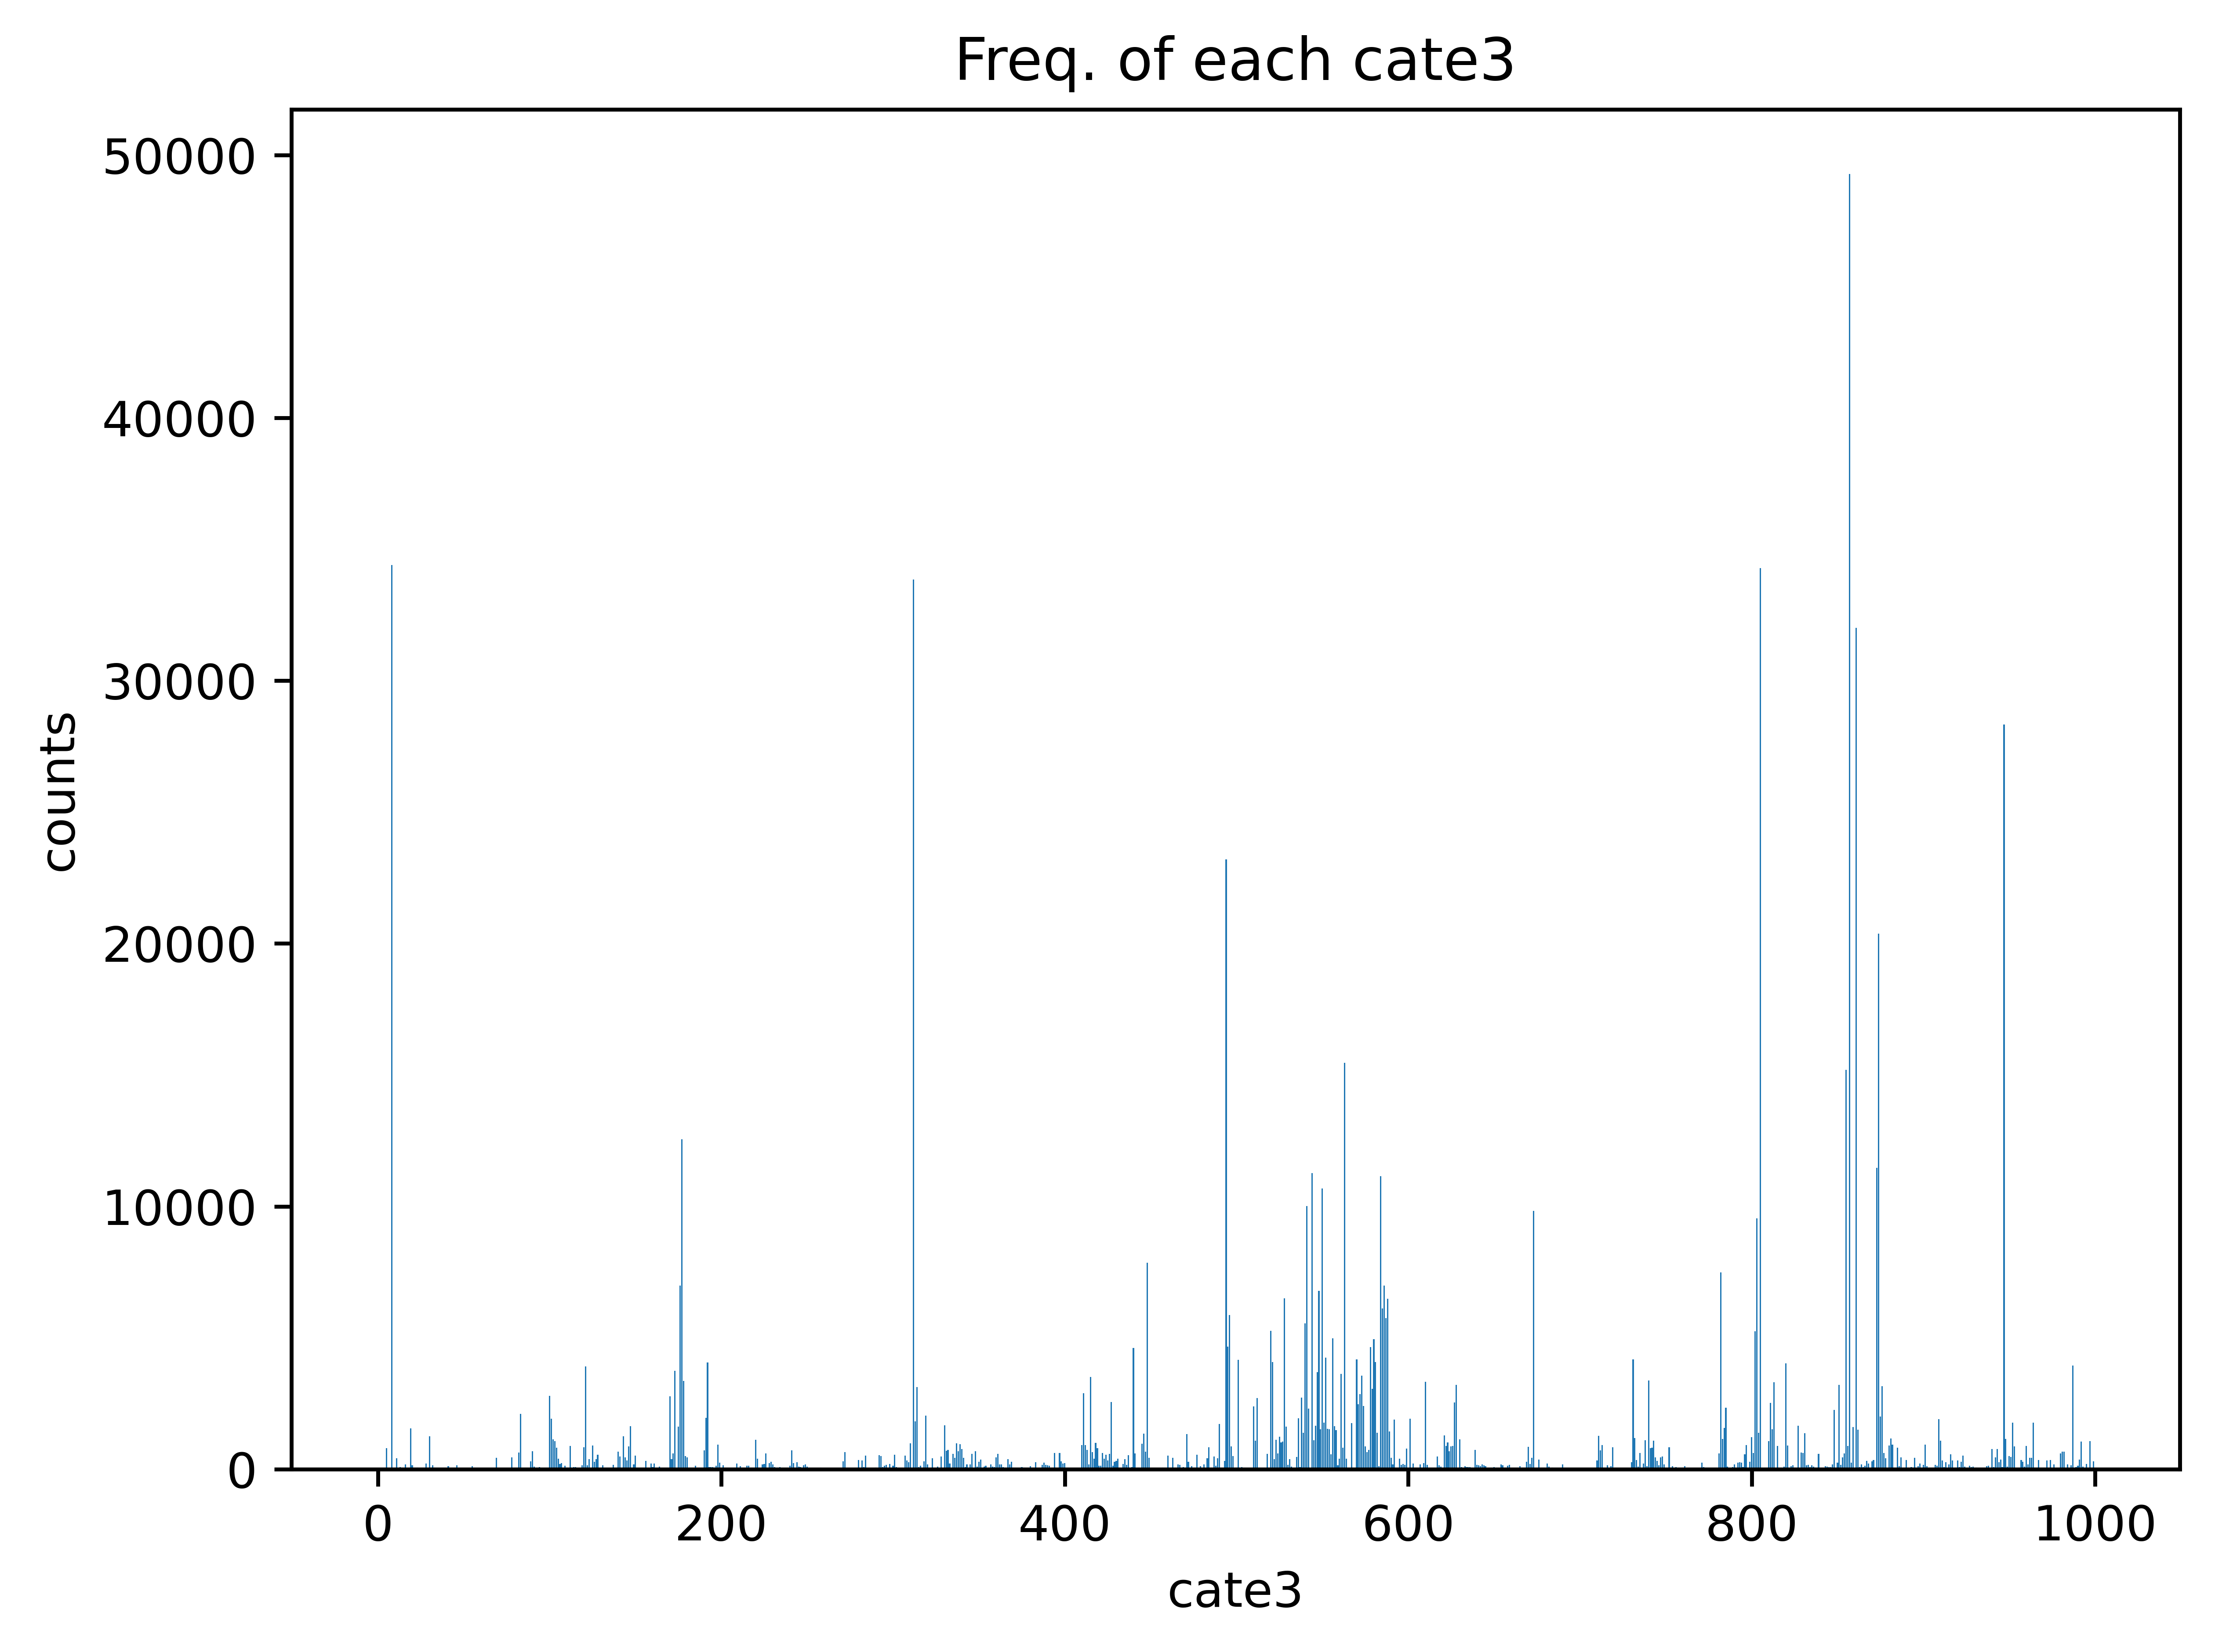

In [19]:
plt.figure(dpi=800)
plt.bar(np.arange(lend_times.shape[0]),lend_times)
plt.title("Freq. of each cate3")
plt.xlabel("cate3")
plt.ylabel("counts")
plt.tight_layout()
plt.savefig(os.path.join("cate3_freq.jpg"))
plt.show()


In [22]:
sorting_by_freq = -np.sort(-lend_times)
sortedcates = np.argsort(-lend_times)
print(sortedcates[:5])

[857   8 805 312 861]


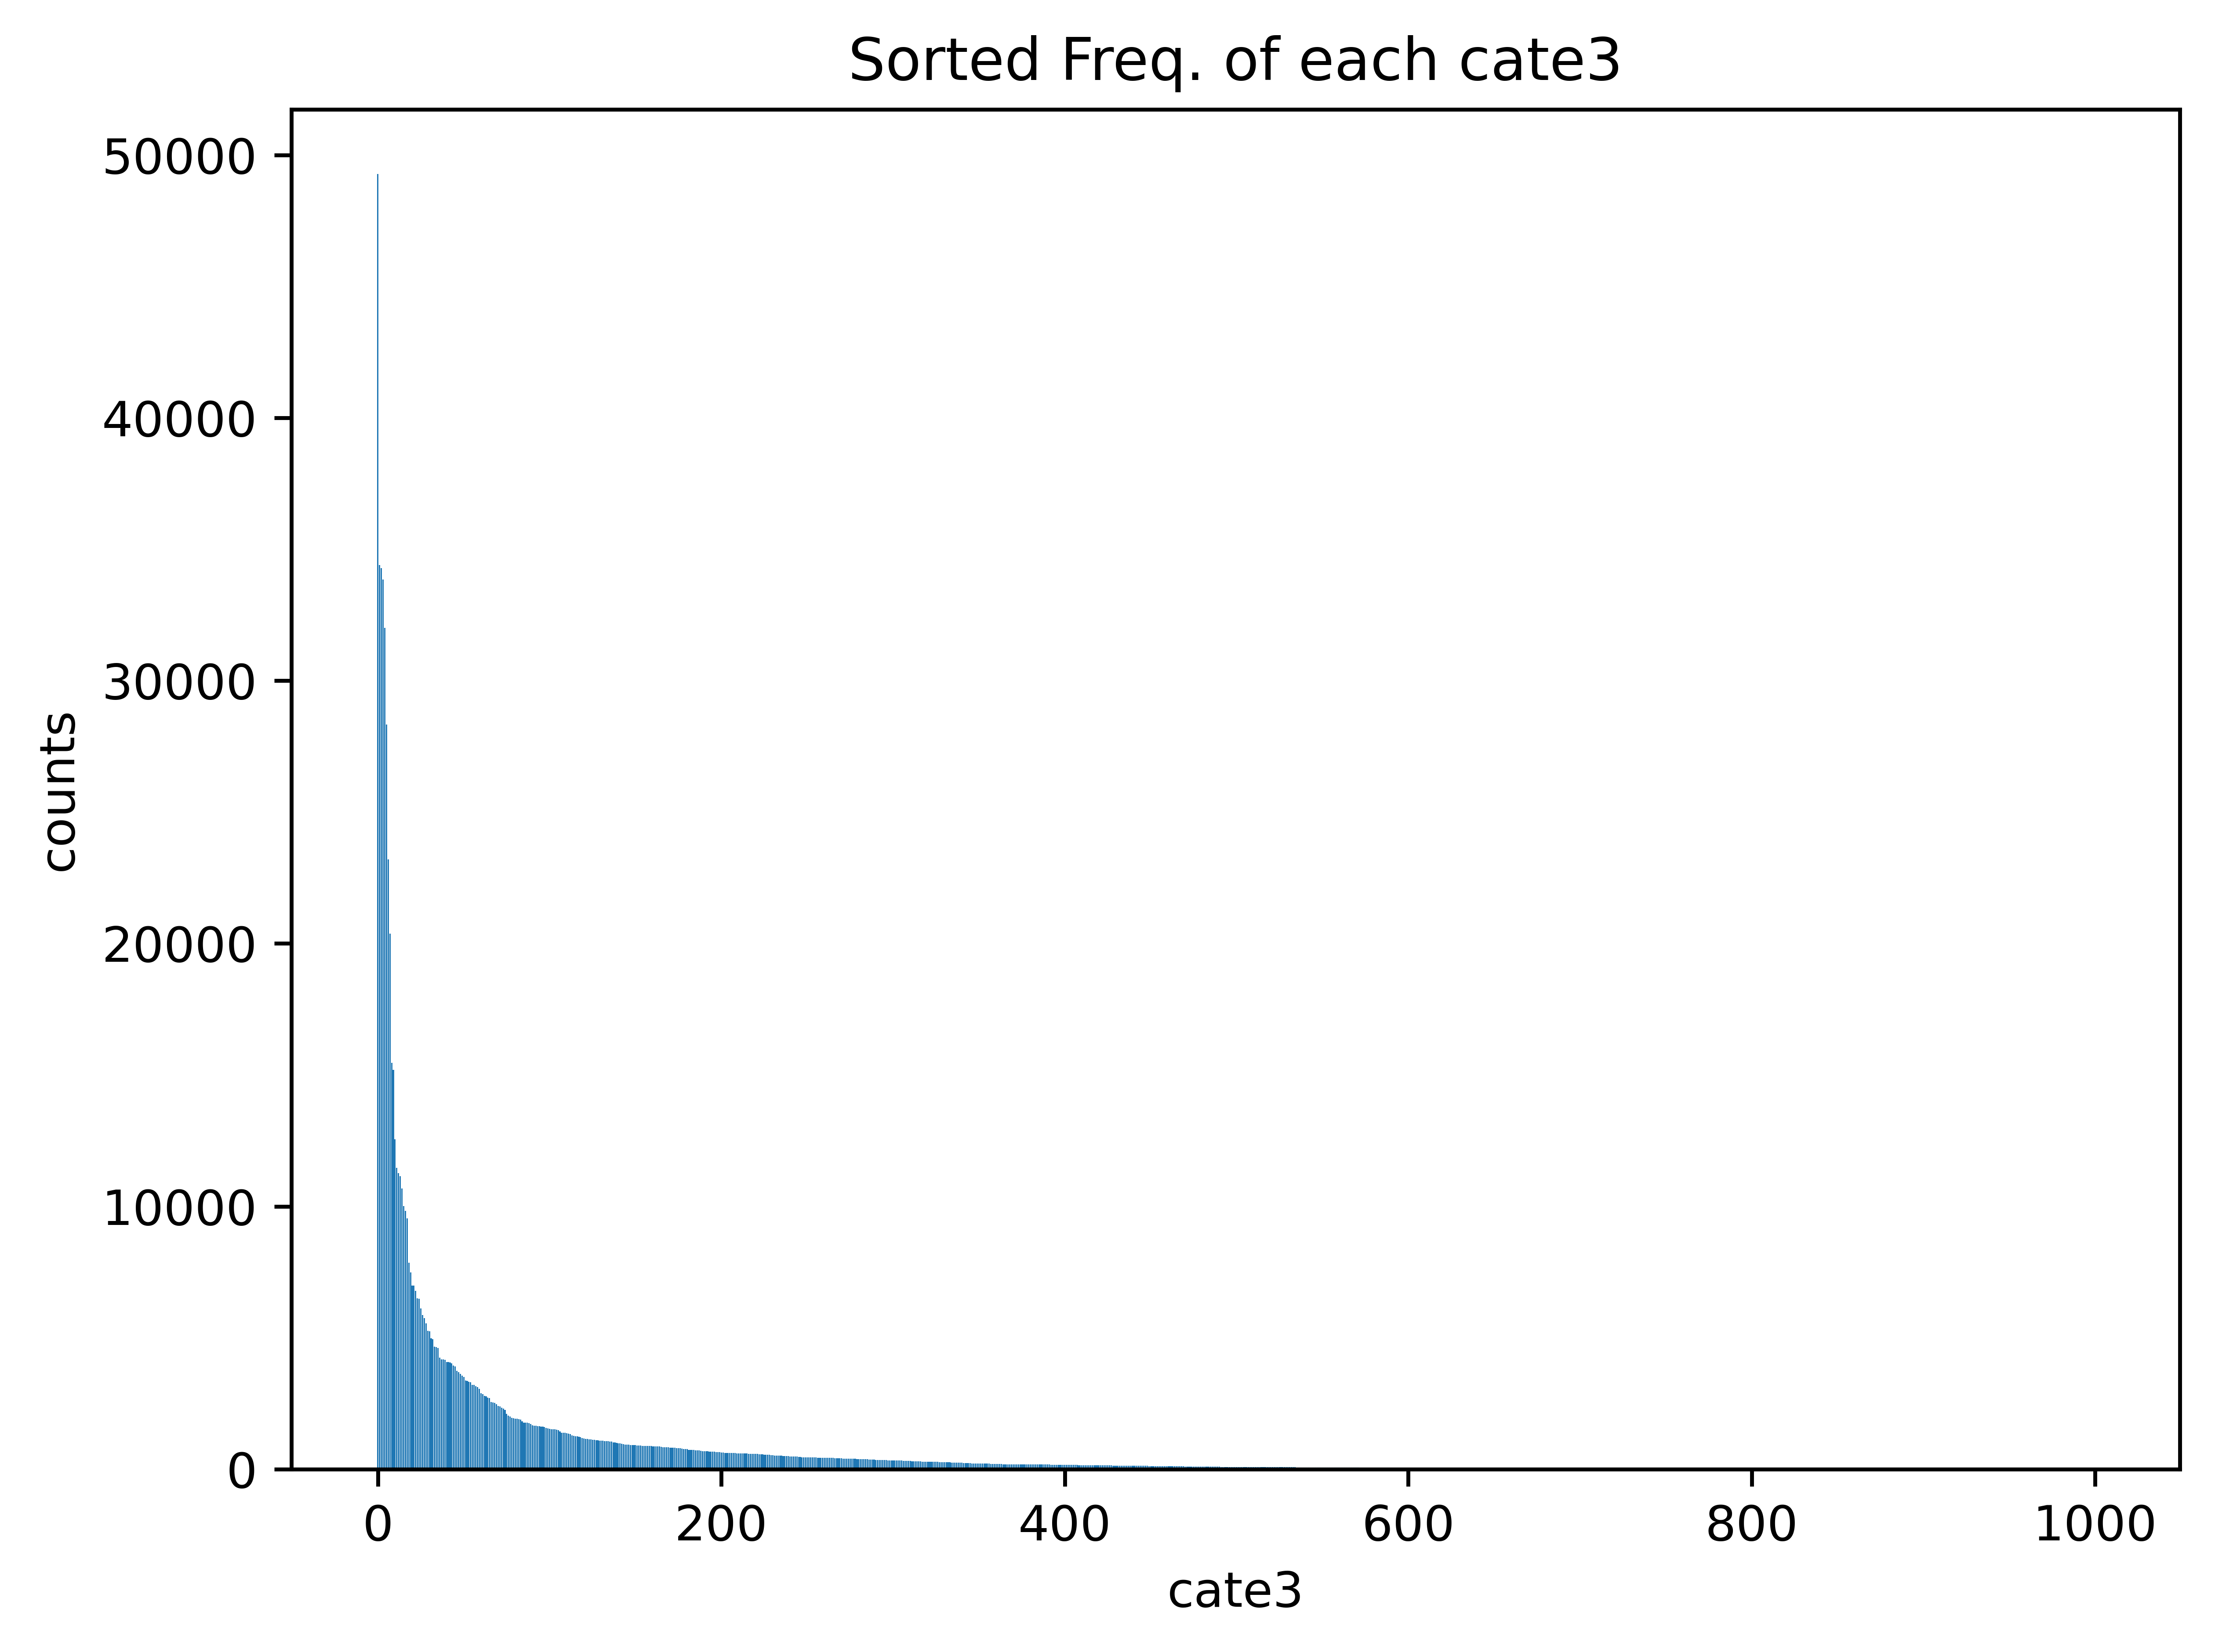

In [20]:
plt.figure(dpi=800)
plt.bar(np.arange(sorting_by_freq.shape[0]),sorting_by_freq)
plt.title("Sorted Freq. of each cate3")
plt.xlabel("cate3")
plt.ylabel("counts")
plt.tight_layout()
plt.savefig(os.path.join("cate3_sortedfreq.jpg"))
plt.show()

In [42]:
def inttocate3(c:int):
    if c < 100:
        if c < 10:
            return f"00{c}"
        return f"0{c}"
    return f"{c}"

In [43]:
highfreq = sortedcates[:200]
highfreq = highfreq.tolist()
highfreq = list(map(inttocate3 , highfreq))
print(highfreq[:5])

['857', '008', '805', '312', '861']


In [44]:
lowfreq = sortedcates[200:]
lowfreq = lowfreq.tolist()
lowfreq  = list(map(inttocate3 , lowfreq))
print(lowfreq[-5:])

['708', '905', '707', '393', '264']


In [34]:
h = np.nonzero(sorting_by_freq[200:])
print(h[0].shape[0])

680


In [45]:
highF_trans = []
for ti in t3:
    ht = list(bi for bi in ti if bi in highfreq)
    if len(ht):
        highF_trans.append(ht)
print(len(highF_trans))

20226


In [46]:
lowF_trans = []
for ti in t3:
    lt = list(bi for bi in ti if bi in lowfreq)
    if len(lt):
        lowF_trans.append(lt)
print(len(lowF_trans))

10312


In [48]:
with open("highF_trans.json", "w+", encoding="utf-8") as hf:
    json.dump(highF_trans, hf, indent=4)
with open("lowF_trans.json", "w+", encoding="utf-8") as lf:
    json.dump(lowF_trans, lf, indent=4)


### Muti-Level AR

In [49]:
from apyori import apriori

In [ ]:
highF_trans = None
lowF_trans = None
with open("highF_trans.json", "r", encoding="utf-8") as h:
    highF_trans=json.load(h)
with open("lowF_trans.json", "r", encoding="utf-8") as l:
    lowF_trans=json.load(l)

In [66]:
print(len(highF_trans))
highAR = list(apriori(
    highF_trans, 
    min_support=0.05, min_confidence=0.51, 
    min_lift=2, max_length=1000
))
print(len(highAR))
highAR_cluster = {}
for i, r in enumerate(highAR):
    pair = r[0] 
    ri = [x for x in pair]
    highAR_cluster[f"{i}"]=ri

with open("highAR.json", "w+", encoding="utf-8") as h:
    json.dump(highAR_cluster, h, indent=4)

20226
39


In [67]:
print(len(lowF_trans))
lowAR = list(apriori(
    lowF_trans, 
    min_support=0.002, min_confidence=0.51, 
    min_lift=1.001, max_length=1000
))
print(len(lowAR))
lowAR_cluster = {}
for i, r in enumerate(lowAR):
    pair = r[0] 
    ri = [x for x in pair]
    lowAR_cluster[f"{i}"]=ri

with open("lowAR.json", "w+", encoding="utf-8") as h:
    json.dump(lowAR_cluster, h, indent=4)


10312
38
